## Import Required Packages and Set File Path

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import brier_score_loss, accuracy_score, log_loss
from sklearn.model_selection import GroupKFold
import xgboost as xgb


# Set the file path
DATA_PATH = "/Users/nicholasrichards/Desktop/march_madness_prediction_project/march-machine-learning-mania-2025/"


## Preparing Dataframes

In [3]:
# Loads tournament seeds data for both men's and women's tournaments
m_tourney_seeds = pd.read_csv(os.path.join(DATA_PATH, "MNCAATourneySeeds.csv")).assign(League="M")
w_tourney_seeds = pd.read_csv(os.path.join(DATA_PATH, "WNCAATourneySeeds.csv")).assign(League="W")
df_seeds = pd.concat([m_tourney_seeds, w_tourney_seeds], ignore_index=True)

# Loads regular season detailed results data for both men's and women's tournaments
m_reg_season = pd.read_csv(os.path.join(DATA_PATH, "MRegularSeasonDetailedResults.csv")).assign(League="M")
w_reg_season = pd.read_csv(os.path.join(DATA_PATH, "WRegularSeasonDetailedResults.csv")).assign(League="W")
df_season_results = pd.concat([m_reg_season, w_reg_season], ignore_index=True)

# Loads NCAA tournament detailed results data for both men's and women's tournaments
m_tourney_results = pd.read_csv(os.path.join(DATA_PATH, "MNCAATourneyDetailedResults.csv")).assign(League="M")
w_tourney_results = pd.read_csv(os.path.join(DATA_PATH, "WNCAATourneyDetailedResults.csv")).assign(League="W")
df_tourney_results = pd.concat([m_tourney_results, w_tourney_results], ignore_index=True)

# Loads team conference data for both men's and women's tournaments
m_team_conferences = pd.read_csv(os.path.join(DATA_PATH, "MTeamConferences.csv")).assign(League="M")
w_team_conferences = pd.read_csv(os.path.join(DATA_PATH, "WTeamConferences.csv")).assign(League="W")
df_team_conferences = pd.concat([m_team_conferences, w_team_conferences], ignore_index=True)

# Loads team data for both men's and women's tournaments 
m_teams = pd.read_csv(os.path.join(DATA_PATH, "MTeams.csv"))
w_teams = pd.read_csv(os.path.join(DATA_PATH, "WTeams.csv"))
df_teams = pd.concat([m_teams, w_teams], ignore_index=True)

# Loads the overall conference data
df_conferences = pd.read_csv(os.path.join(DATA_PATH, "Conferences.csv"))

# Load men's team coaches data
df_team_coaches = pd.read_csv(os.path.join(DATA_PATH, "MTeamCoaches.csv"))

# Load conference tournament games data for both men's and women's tournaments
m_conf_tourney_games = pd.read_csv(os.path.join(DATA_PATH, "MConferenceTourneyGames.csv")).assign(League="M")
w_conf_tourney_games = pd.read_csv(os.path.join(DATA_PATH, "WConferenceTourneyGames.csv")).assign(League="W")
df_conf_tourney_games = pd.concat([m_conf_tourney_games, w_conf_tourney_games], ignore_index=True)

# Load the Sample Submission Stage 2 file
df_sample_submission = pd.read_csv(os.path.join(DATA_PATH, "SampleSubmissionStage2.csv"))

df_season_results.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,League
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,M
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,M
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,M
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,M
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,M


## Creating Matrix Completion Dataframe

### Adapting Regular Season Results for Matrix Completion Model

In [4]:
# Renaming dictionaries as provided:
winner_rename = {
    "WTeamID": "TeamID",
    "WScore": "TeamScore",
    "LScore": "OppScore",
    "WFGM": "FGM",
    "WFGA": "FGA",
    "WFGM3": "FGM3",
    "WFGA3": "FGA3",
    "WFTM": "FTM",
    "WFTA": "FTA",
    "WOR": "OR",
    "WDR": "DR",
    "WAst": "Ast",
    "WTO": "TO",
    "WStl": "Stl",
    "WBlk": "Blk",
    "WPF": "PF",
    "LFGM": "OppFGM",
    "LFGA": "OppFGA",
    "LFGM3": "OppFGM3",
    "LFGA3": "OppFGA3",
    "LFTM": "OppFTM",
    "LFTA": "OppFTA",
    "LOR": "OppOR",
    "LDR": "OppDR",
    "LAst": "OppAst",
    "LTO": "OppTO",
    "LStl": "OppStl",
    "LBlk": "OppBlk",
    "LPF": "OppPF"
}

loser_rename = {
    "LTeamID": "TeamID",
    "LScore": "TeamScore",
    "WScore": "OppScore",
    "LFGM": "FGM",
    "LFGA": "FGA",
    "LFGM3": "FGM3",
    "LFGA3": "FGA3",
    "LFTM": "FTM",
    "LFTA": "FTA",
    "LOR": "OR",
    "LDR": "DR",
    "LAst": "Ast",
    "LTO": "TO",
    "LStl": "Stl",
    "LBlk": "Blk",
    "LPF": "PF",
    "WFGM": "OppFGM",
    "WFGA": "OppFGA",
    "WFGM3": "OppFGM3",
    "WFGA3": "OppFGA3",
    "WFTM": "OppFTM",
    "WFTA": "OppFTA",
    "WOR": "OppOR",
    "WDR": "OppDR",
    "WAst": "OppAst",
    "WTO": "OppTO",
    "WStl": "OppStl",
    "WBlk": "OppBlk",
    "WPF": "OppPF"
}

# Working on a copy of the original dataframe
df_temp = df_season_results.copy()

# Creates new columns with lower team as TeamID, higher as OppTeamID and Outcome from lower team's perspective
df_temp['TeamID'] = np.minimum(df_temp['WTeamID'], df_temp['LTeamID'])
df_temp['OppTeamID'] = np.maximum(df_temp['WTeamID'], df_temp['LTeamID'])
df_temp['Outcome'] = (df_temp['WTeamID'] == df_temp['TeamID']).astype(int)

# Build a mapping from new column name to tuple (winner_source, loser_source)
mapping = {}
for orig, new_name in winner_rename.items():
    mapping[new_name] = (orig, None)
for orig, new_name in loser_rename.items():
    if new_name in mapping:
        winner_source = mapping[new_name][0]
        mapping[new_name] = (winner_source, orig)
    else:
        mapping[new_name] = (None, orig)

# For each new column, selects values based on Outcome
for new_col, (w_source, l_source) in mapping.items():
    if (w_source is not None) and (l_source is not None):
        df_temp[new_col] = np.where(df_temp['Outcome'] == 1, df_temp[w_source], df_temp[l_source])
    elif w_source is not None:
        df_temp[new_col] = df_temp[w_source]
    elif l_source is not None:
        df_temp[new_col] = df_temp[l_source]

# Drops original detailed stat columns and the original team IDs
detailed_cols = set(winner_rename.keys()).union(set(loser_rename.keys()))
cols_to_drop = ['WTeamID', 'LTeamID'] + list(detailed_cols)
df_cf = df_temp.drop(columns=cols_to_drop, errors='ignore')

# Ensures that Season and DayNum are in the dataframe
keep_front = ['Season', 'DayNum', 'TeamID', 'OppTeamID', 'Outcome']
other_cols = [col for col in df_cf.columns if col not in keep_front]
new_order = keep_front + other_cols
df_cf = df_cf[new_order]

if 'NumOT' in df_cf.columns:
    df_cf['Min'] = 40 + 5 * df_cf['NumOT']
    cols = list(df_cf.columns)
    if "NumOT" in cols and "Min" in cols:
        idx = cols.index("NumOT")
        cols.remove("Min")
        cols.insert(idx + 1, "Min")
        df_cf = df_cf[cols]

df_cf.head()


,Season,DayNum,TeamID,OppTeamID,Outcome,WLoc,NumOT,Min,League,TeamScore,...,OppFGA3,OppFTM,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF
0,2003,10,1104,1328,1,N,0,40,M,68,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,1393,1,N,0,40,M,70,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,1437,1,N,0,40,M,73,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,1457,1,N,0,40,M,56,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1208,1400,0,N,0,40,M,71,...,14,11,13,17,22,12,14,4,4,20


### Creating Shooting Statistics for CF Dataframe

In [5]:
# Calculates team shooting percentages
df_cf["FG_pct"] = np.where(
    df_cf["FGA"] > 0,
    df_cf["FGM"] / df_cf["FGA"],
    0
)
df_cf["FG3_pct"] = np.where(
    df_cf["FGA3"] > 0,
    df_cf["FGM3"] / df_cf["FGA3"],
    0
)
df_cf["FT_pct"] = np.where(
    df_cf["FTA"] > 0,
    df_cf["FTM"] / df_cf["FTA"],
    0
)

# Calculates opponent shooting percentages
df_cf["Opp_FG_pct"] = np.where(
    df_cf["OppFGA"] > 0,
    df_cf["OppFGM"] / df_cf["OppFGA"],
    0
)
df_cf["Opp_FG3_pct"] = np.where(
    df_cf["OppFGA3"] > 0,
    df_cf["OppFGM3"] / df_cf["OppFGA3"],
    0
)
df_cf["Opp_FT_pct"] = np.where(
    df_cf["OppFTA"] > 0,
    df_cf["OppFTM"] / df_cf["OppFTA"],
    0
)

# Calculates effective field goal percentage
df_cf["eFG_pct"] = np.where(
    df_cf["FGA"] > 0,
    (df_cf["FGM"] + 0.5 * df_cf["FGM3"]) / df_cf["FGA"],
    0
)

# Calculates effective field goal percentage for opponent
df_cf["Opp_eFG_pct"] = np.where(
    df_cf["OppFGA"] > 0,
    (df_cf["OppFGM"] + 0.5 * df_cf["OppFGM3"]) / df_cf["OppFGA"],
    0
)

df_cf.sample(10, random_state=349)


,Season,DayNum,TeamID,OppTeamID,Outcome,WLoc,NumOT,Min,League,TeamScore,...,OppBlk,OppPF,FG_pct,FG3_pct,FT_pct,Opp_FG_pct,Opp_FG3_pct,Opp_FT_pct,eFG_pct,Opp_eFG_pct
174255,2020,96,3184,3188,1,A,0,40,W,68,...,1,19,0.418182,0.444444,0.666667,0.254237,0.133333,0.500000,0.490909,0.271186
70398,2016,111,1371,1385,1,A,0,40,M,62,...,10,26,0.365385,0.400000,0.600000,0.442308,0.263158,0.416667,0.423077,0.490385
81460,2018,117,1323,1448,1,A,0,40,M,76,...,7,15,0.438596,0.347826,0.900000,0.440678,0.346154,0.666667,0.508772,0.516949
129599,2012,23,3119,3264,1,H,0,40,W,58,...,3,12,0.456522,0.600000,0.684211,0.372093,0.176471,0.571429,0.489130,0.406977
99681,2022,84,1314,1439,1,H,0,40,M,78,...,2,21,0.365079,0.400000,0.846154,0.465517,0.388889,0.636364,0.444444,0.525862
68436,2016,71,1123,1444,1,A,0,40,M,74,...,1,16,0.518519,0.454545,0.615385,0.365385,0.277778,0.724138,0.611111,0.413462
55435,2014,9,1337,1415,1,A,0,40,M,69,...,4,19,0.416667,0.500000,0.769231,0.448276,0.187500,0.647059,0.510417,0.474138
129539,2012,21,3265,3343,0,H,0,40,W,51,...,3,9,0.372549,0.380952,0.555556,0.400000,0.357143,0.833333,0.450980,0.483333
32096,2009,87,1204,1359,0,H,0,40,M,46,...,0,11,0.351852,0.000000,0.727273,0.480769,0.391304,0.909091,0.351852,0.567308
89555,2020,56,1260,1434,1,A,0,40,M,66,...,9,23,0.420000,0.357143,0.633333,0.431034,0.333333,0.666667,0.470000,0.508621


### Creating Possession and Pace Statistics for CF Dataframe

In [6]:
# Calculates team possessions
df_cf["Team_Possessions"] = (
    df_cf["FGA"] +
    0.44 * df_cf["FTA"] -
    df_cf["OR"] +
    df_cf["TO"]
)

# Calculates opponent possessions similarly
df_cf["Opp_Possessions"] = (
    df_cf["OppFGA"] +
    0.44 * df_cf["OppFTA"] -
    df_cf["OppOR"] +
    df_cf["OppTO"]
)

# Calculates possession margin
df_cf["PossessionMargin"] = (
    df_cf["Team_Possessions"] - df_cf["Opp_Possessions"]
)

# Calculates team's tempo
df_cf["Team_Tempo"] = df_cf["Team_Possessions"] / (df_cf["Min"] / 40)

# Calculates opponent's tempo
df_cf["Opp_Tempo"] = df_cf["Opp_Possessions"] / (df_cf["Min"] / 40)

df_cf.sample(10, random_state=529)

,Season,DayNum,TeamID,OppTeamID,Outcome,WLoc,NumOT,Min,League,TeamScore,...,Opp_FG_pct,Opp_FG3_pct,Opp_FT_pct,eFG_pct,Opp_eFG_pct,Team_Possessions,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo
168194,2019,76,3321,3458,1,H,0,40,W,72,...,0.246154,0.125000,0.611111,0.439655,0.269231,62.88,64.92,-2.04,62.88,64.92
136497,2013,68,3183,3240,1,H,0,40,W,76,...,0.289855,0.130435,0.769231,0.400000,0.311594,77.40,77.72,-0.32,77.40,77.72
131681,2012,75,3372,3427,0,H,0,40,W,46,...,0.309524,0.222222,0.709677,0.330000,0.333333,68.56,67.64,0.92,68.56,67.64
145900,2015,41,3294,3429,0,H,0,40,W,61,...,0.431818,0.200000,0.666667,0.419355,0.443182,66.60,69.16,-2.56,66.60,69.16
170614,2020,1,3200,3323,0,A,0,40,W,55,...,0.365385,0.200000,0.606061,0.375000,0.384615,72.88,75.52,-2.64,72.88,75.52
36015,2010,58,1159,1306,0,H,0,40,M,55,...,0.391304,0.142857,0.615385,0.358333,0.423913,70.24,70.16,0.08,70.24,70.16
50031,2013,7,1401,1407,1,H,0,40,M,83,...,0.436364,0.406250,1.000000,0.590909,0.554545,58.80,57.76,1.04,58.80,57.76
164700,2018,117,3111,3114,0,H,0,40,W,35,...,0.421875,0.400000,0.428571,0.282609,0.453125,61.48,63.08,-1.60,61.48,63.08
167919,2019,71,3244,3251,0,A,0,40,W,61,...,0.551020,0.454545,0.571429,0.445455,0.602041,67.04,70.16,-3.12,67.04,70.16
150004,2016,16,3306,3357,1,A,0,40,W,81,...,0.400000,0.416667,0.611111,0.535088,0.483333,66.44,68.92,-2.48,66.44,68.92


### Creating Efficiency Statistics for CF Dataframe

In [7]:
# Calculates team's offensive efficiency
df_cf["Team_OffEff"] = (df_cf["TeamScore"] / df_cf["Team_Possessions"]) * 100

# Calculates team's defensive efficiency
df_cf["Team_DefEff"] = (df_cf["OppScore"] / df_cf["Opp_Possessions"]) * 100

# Calculates opponent's offensive efficiency
df_cf["Opp_OffEff"] = (df_cf["OppScore"] / df_cf["Opp_Possessions"]) * 100

# Calculates opponent's defensive efficiency
df_cf["Opp_DefEff"] = (df_cf["TeamScore"] / df_cf["Team_Possessions"]) * 100

df_cf.sample(10, random_state=529)


,Season,DayNum,TeamID,OppTeamID,Outcome,WLoc,NumOT,Min,League,TeamScore,...,Opp_eFG_pct,Team_Possessions,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo,Team_OffEff,Team_DefEff,Opp_OffEff,Opp_DefEff
168194,2019,76,3321,3458,1,H,0,40,W,72,...,0.269231,62.88,64.92,-2.04,62.88,64.92,114.503817,70.856439,70.856439,114.503817
136497,2013,68,3183,3240,1,H,0,40,W,76,...,0.311594,77.40,77.72,-0.32,77.40,77.72,98.191214,68.193515,68.193515,98.191214
131681,2012,75,3372,3427,0,H,0,40,W,46,...,0.333333,68.56,67.64,0.92,68.56,67.64,67.094516,73.920757,73.920757,67.094516
145900,2015,41,3294,3429,0,H,0,40,W,61,...,0.443182,66.60,69.16,-2.56,66.60,69.16,91.591592,93.984962,93.984962,91.591592
170614,2020,1,3200,3323,0,A,0,40,W,55,...,0.384615,72.88,75.52,-2.64,72.88,75.52,75.466520,79.449153,79.449153,75.466520
36015,2010,58,1159,1306,0,H,0,40,M,55,...,0.423913,70.24,70.16,0.08,70.24,70.16,78.302961,89.794755,89.794755,78.302961
50031,2013,7,1401,1407,1,H,0,40,M,83,...,0.554545,58.80,57.76,1.04,58.80,57.76,141.156463,112.534626,112.534626,141.156463
164700,2018,117,3111,3114,0,H,0,40,W,35,...,0.453125,61.48,63.08,-1.60,61.48,63.08,56.929083,96.702600,96.702600,56.929083
167919,2019,71,3244,3251,0,A,0,40,W,61,...,0.602041,67.04,70.16,-3.12,67.04,70.16,90.990453,95.496009,95.496009,90.990453
150004,2016,16,3306,3357,1,A,0,40,W,81,...,0.483333,66.44,68.92,-2.48,66.44,68.92,121.914509,100.116077,100.116077,121.914509


## Matrix Completion Model Using SVD++

In [8]:
df_cf

,Season,DayNum,TeamID,OppTeamID,Outcome,WLoc,NumOT,Min,League,TeamScore,...,Opp_eFG_pct,Team_Possessions,Opp_Possessions,PossessionMargin,Team_Tempo,Opp_Tempo,Team_OffEff,Team_DefEff,Opp_OffEff,Opp_DefEff
0,2003,10,1104,1328,1,N,0,40,M,68,...,0.433962,74.92,70.68,4.24,74.92,70.68,90.763481,87.719298,87.719298,90.763481
1,2003,10,1272,1393,1,N,0,40,M,70,...,0.402985,68.36,67.80,0.56,68.36,67.80,102.399064,92.920354,92.920354,102.399064
2,2003,11,1266,1437,1,N,0,40,M,73,...,0.321918,63.76,64.12,-0.36,63.76,64.12,114.491844,95.134124,95.134124,114.491844
3,2003,11,1296,1457,1,N,0,40,M,56,...,0.428571,57.64,57.60,0.04,57.64,57.60,97.154754,86.805556,86.805556,97.154754
4,2003,11,1208,1400,0,N,0,40,M,71,...,0.540984,62.88,63.72,-0.84,62.88,63.72,112.913486,120.841180,120.841180,112.913486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200585,2025,131,3413,3471,0,A,0,40,W,66,...,0.451613,74.16,77.32,-3.16,74.16,77.32,88.996764,96.999483,96.999483,88.996764
200586,2025,132,3192,3476,1,H,0,40,W,66,...,0.403509,61.92,61.76,0.16,61.92,61.76,106.589147,79.339378,79.339378,106.589147
200587,2025,132,3119,3250,0,H,0,40,W,62,...,0.655556,62.40,62.48,-0.08,62.40,62.48,99.358974,118.437900,118.437900,99.358974
200588,2025,132,3125,3293,0,N,0,40,W,62,...,0.648148,69.16,68.60,0.56,69.16,68.60,89.647195,120.991254,120.991254,89.647195


### Create Score Matrix

In [40]:
import itertools
import pandas as pd

# 1. Filter to 2025 and compute score difference
df_cf_2025 = df_cf[df_cf['Season'] == 2025].copy()
df_cf_2025['score_diff'] = df_cf_2025['TeamScore'] - df_cf_2025['OppScore']

# 2. Build league→team mapping
teams_from_team = df_cf_2025[['TeamID','League']].drop_duplicates()
teams_from_opp  = df_cf_2025[['OppTeamID','League']].drop_duplicates() \
                          .rename(columns={'OppTeamID':'TeamID'})
team_league_map = pd.concat([teams_from_team, teams_from_opp]) \
                       .drop_duplicates(subset='TeamID')

# 3. Compute observed mean diffs **and mirror them**  
observed = (
    df_cf_2025
      .groupby(['League','TeamID','OppTeamID'])['score_diff']
      .mean()
      .reset_index()
)

# create the “reflected” entries
observed_rev = observed.rename(columns={'TeamID':'OppTeamID','OppTeamID':'TeamID'})
observed_rev['score_diff'] = -observed_rev['score_diff']

# combine original + reflected
observed_full = pd.concat([observed, observed_rev], ignore_index=True)

# 4. Build full directed score‐matrix per league
score_dfs = []
for league in team_league_map['League'].unique():
    teams = (
        team_league_map
          .loc[team_league_map['League']==league, 'TeamID']
          .astype(int)
          .tolist()
    )
    pairs = list(itertools.permutations(teams, 2))
    df_pairs = pd.DataFrame(pairs, columns=['TeamID','OppTeamID'])
    df_pairs['League'] = league
    df_pairs['Season'] = 2025

    # merge in the full set of observed diffs
    df_score = df_pairs.merge(
        observed_full,
        on=['League','TeamID','OppTeamID'],
        how='left'
    )
    score_dfs.append(df_score)

score_df = pd.concat(score_dfs, ignore_index=True)

# 5. Sanity check per league
total = 0
for league in team_league_map['League'].unique():
    n = len(team_league_map.loc[team_league_map['League']==league])
    total += n*(n-1)
    print(f"{league}: {n} teams → {n*(n-1)} directed pairs")
print(f"Total directed pairs: {len(score_df)} (should be {total})")

print(score_df.head())




M: 364 teams → 132132 directed pairs
W: 362 teams → 130682 directed pairs
Total directed pairs: 262814 (should be 262814)
   TeamID  OppTeamID League  Season  score_diff
0    1104       1112      M    2025         NaN
1    1104       1103      M    2025         NaN
2    1104       1107      M    2025         NaN
3    1104       1130      M    2025         NaN
4    1104       1133      M    2025         NaN


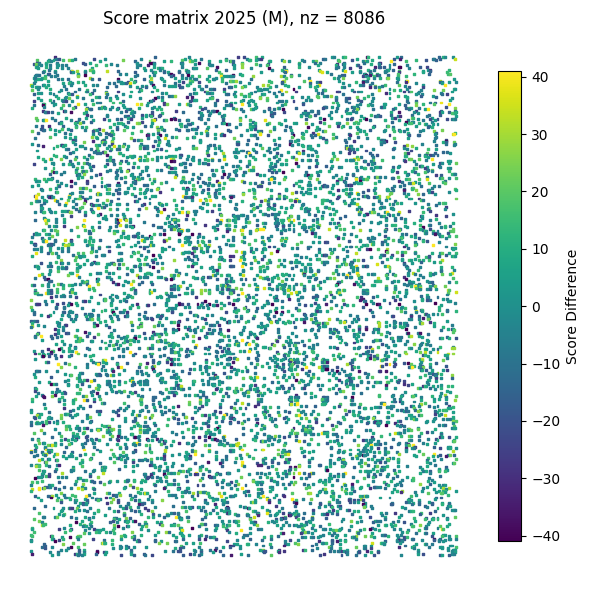

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Select just one league
league = 'M'  
df_l   = score_df[score_df['League'] == league]

# 2) Build your square score-diff matrix, keeping NaNs
teams = sorted(df_l['TeamID'].astype(int).unique())
mat_df = (
    df_l
      .pivot(index='TeamID', columns='OppTeamID', values='score_diff')
      .reindex(index=teams, columns=teams)
)
mat = mat_df.values  # has NaNs for unplayed matchups

# 3) Find non-NaN entries and their values
rows, cols = np.where(~np.isnan(mat))
vals       = mat[rows, cols]
nz         = len(vals)

# 4) Determine a sensible color range on the real data
vmin, vmax = np.percentile(vals, [1, 99])

# 5) Plot with scatter
plt.figure(figsize=(6,6))
plt.scatter(cols, rows, c=vals, cmap='viridis',
            vmin=vmin, vmax=vmax, s=2, marker='s')
plt.gca().invert_yaxis()
plt.title(f"Score matrix 2025 ({league}), nz = {nz}", fontsize=12)
plt.axis('off')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Score Difference', fontsize=10)
plt.tight_layout()
plt.show()



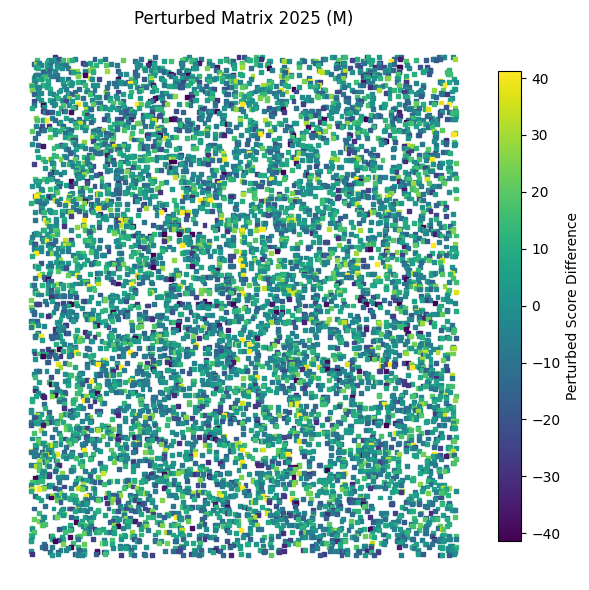

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Extract your real score‐diff matrix for league “M”
df_l = score_df[score_df['League'] == 'M']
teams = sorted(df_l['TeamID'].astype(int).unique())

mat_df = (
    df_l
      .pivot(index='TeamID', columns='OppTeamID', values='score_diff')
      .reindex(index=teams, columns=teams)
)
mat = mat_df.values  # has NaNs where unobserved

# 2) Get the observed entries
rows, cols = np.where(~np.isnan(mat))
vals       = mat[rows, cols]

# 3) Add noise only to those values
rng = np.random.default_rng(1)
noise_level = 3.0   # adjust to taste
vals_noisy = vals + rng.normal(scale=noise_level, size=vals.shape)

# 4) Determine color limits (based on noisy data)
vmin, vmax = np.percentile(vals_noisy, [1, 99])

# 5) Plot
plt.figure(figsize=(6,6))
sc = plt.scatter(
    cols, rows,
    c=vals_noisy,
    cmap='viridis',
    vmin=vmin,
    vmax=vmax,
    s=8,
    marker='s'
)
plt.gca().invert_yaxis()
plt.title("Perturbed Matrix 2025 (M)")
plt.axis('off')
cbar = plt.colorbar(sc, fraction=0.046, pad=0.04)
cbar.set_label('Perturbed Score Difference')
plt.tight_layout()
plt.show()


### Matrix Completion Model

In [30]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, SVDpp

# — assume score_df has columns ['League','TeamID','OppTeamID','score_diff'] —

def complete_svdpp_league(df_league, sigma=5.0, n_factors=50, reg_all=0.02):
    # a) perturb only observed diffs within this league
    df_obs = df_league.dropna(subset=['score_diff']).copy()
    df_obs['pert_diff'] = df_obs['score_diff'] + np.random.randn(len(df_obs)) * sigma

    # b) build & train SVD++
    reader = Reader(rating_scale=(df_obs['pert_diff'].min(), df_obs['pert_diff'].max()))
    data = Dataset.load_from_df(df_obs[['TeamID','OppTeamID','pert_diff']], reader)
    trainset = data.build_full_trainset()
    algo = SVDpp(n_factors=n_factors, reg_all=reg_all)
    algo.fit(trainset)

    # c) predict full matrix for this league's teams
    teams = sorted(df_league['TeamID'].unique())
    n = len(teams)
    mat = np.zeros((n, n), dtype=float)
    for i, ti in enumerate(teams):
        for j, tj in enumerate(teams):
            mat[i, j] = 0.0 if ti == tj else algo.predict(ti, tj).est
    return mat, teams

# — ensemble + logistic, per‐league —
n_perturb = 30
rows = []

def sigmoid(x, k=0.1):
    return 1.0 / (1.0 + np.exp(-k * x))

for league in score_df['League'].unique():
    df_league = score_df[score_df['League'] == league]
    mats = []
    for _ in range(n_perturb):
        mat, teams = complete_svdpp_league(df_league,
                                           sigma=5.0,
                                           n_factors=50,
                                           reg_all=0.02)
        mats.append(mat)
    mats = np.stack(mats)  # shape (n_perturb, n, n)
    
    # average win‐probabilities
    mean_probs = sigmoid(mats).mean(axis=0)
    
    # flatten to long form, keeping league
    for i, ti in enumerate(teams):
        for j, tj in enumerate(teams):
            if ti == tj:
                continue
            rows.append({
                'League':    league,
                'TeamID':    ti,
                'OppTeamID': tj,
                'win_prob':  mean_probs[i, j]
            })

prob_df = pd.DataFrame(rows)
print(prob_df.head())
print("Total directed match‐ups:", len(prob_df))


  League  TeamID  OppTeamID  win_prob
0      M    1101       1102  0.448783
1      M    1101       1103  0.448783
2      M    1101       1104  0.448783
3      M    1101       1105  0.448783
4      M    1101       1106  0.373310
Total directed match‐ups: 262814


In [32]:
import pandas as pd

# — assume prob_df has every ordered pair (i,j) —
# keep only one per matchup
pred_df = prob_df[prob_df['TeamID'] < prob_df['OppTeamID']].copy()

# now attach Season and rename your probability column
pred_df['Season'] = 2025
pred_df.rename(columns={'win_prob': 'Predicted_Outcome'}, inplace=True)

# reuse your create_submission_row helper
def create_submission_row(row):
    season = row['Season']
    t1     = row['TeamID']
    t2     = row['OppTeamID']
    prob   = row['Predicted_Outcome']
    sid    = f"{season}_{str(t1).zfill(4)}_{str(t2).zfill(4)}"
    return pd.Series({'ID': sid, 'Pred': prob})

# build the final submission
submission_df = (
    pred_df
      .apply(create_submission_row, axis=1)
      .sort_values('ID')
      .reset_index(drop=True)
)

# sanity check — should be 131,407
print("Rows in submission:", len(submission_df))

submission_df.to_csv("matrix_completion_2025_final.csv", index=False)
print(submission_df.head())


Rows in submission: 131407
               ID      Pred
0  2025_1101_1102  0.448783
1  2025_1101_1103  0.448783
2  2025_1101_1104  0.448783
3  2025_1101_1105  0.448783
4  2025_1101_1106  0.373310
